In [1]:
# 구글 드라이브의 파일 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 코랩에서 접근하고 싶은 파일들을 먼저 압축하고
# 구글 드라이브에 업로드 한 후
# 코랩과 구글 드라이브를 연동시키고
# 현재 화면의 좌측 부분의 파일 아이콘을 선택하여
# 해당 파일을 찾아 우클릭 하고 경로 복사 후 압축 해제
!unzip "/content/drive/MyDrive/open.zip"

In [3]:
# 데이콘 리더 보드 점수 => 0.5424976401

# 최종 수정 2023.05.15 (실행일 동일)
# 해당 코드는 코랩 GPU T4 고용량 RAM에서 실행시킨 결과이며 v2.1.1 버전에서 리팩토링만 진행하였음 

## Import

In [4]:
import pandas as pd
import numpy as np
import random
import glob
import cv2
import re
import os

# pip3 install torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# pip3 install albumentations --user
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# pip3 install torchvision
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn import preprocessing
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as mat_plt

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [6]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':10,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':32,
    'SEED':41
}

## Fixed RandomSeed

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Pre-processing

In [8]:
# 학습용 이미지 폴더 경로 수정
# all_img_list = glob.glob(os.path.join(os.path.pardir, os.path.pardir, 'open', 'train', ) + '/*/*')
all_img_list = glob.glob('/content/train/*/*')
print('all_img_list :', all_img_list)

all_img_list : ['/content/train/면불량/27.png', '/content/train/면불량/64.png', '/content/train/면불량/94.png', '/content/train/면불량/58.png', '/content/train/면불량/11.png', '/content/train/면불량/20.png', '/content/train/면불량/49.png', '/content/train/면불량/2.png', '/content/train/면불량/77.png', '/content/train/면불량/87.png', '/content/train/면불량/51.png', '/content/train/면불량/32.png', '/content/train/면불량/69.png', '/content/train/면불량/68.png', '/content/train/면불량/62.png', '/content/train/면불량/15.png', '/content/train/면불량/54.png', '/content/train/면불량/19.png', '/content/train/면불량/89.png', '/content/train/면불량/75.png', '/content/train/면불량/70.png', '/content/train/면불량/93.png', '/content/train/면불량/47.png', '/content/train/면불량/18.png', '/content/train/면불량/5.png', '/content/train/면불량/23.png', '/content/train/면불량/56.png', '/content/train/면불량/81.png', '/content/train/면불량/96.png', '/content/train/면불량/44.png', '/content/train/면불량/41.png', '/content/train/면불량/88.png', '/content/train/면불량/34.png', '/content/train/면불량/48.png', 

In [9]:
df = pd.DataFrame(columns=['img_path', 'label'])
df['img_path'] = all_img_list

# 학습용 이미지 폴더 경로 수정
# df['label'] = df['img_path'].apply(lambda x : str(x).split('\\')[4])
df['label'] = df['img_path'].apply(lambda x : str(x).split('/')[3])
print('df :', df)

df :                            img_path   label
0         /content/train/면불량/27.png     면불량
1         /content/train/면불량/64.png     면불량
2         /content/train/면불량/94.png     면불량
3         /content/train/면불량/58.png     면불량
4         /content/train/면불량/11.png     면불량
...                             ...     ...
3452  /content/train/걸레받이수정/201.png  걸레받이수정
3453   /content/train/걸레받이수정/14.png  걸레받이수정
3454  /content/train/걸레받이수정/284.png  걸레받이수정
3455  /content/train/걸레받이수정/262.png  걸레받이수정
3456  /content/train/걸레받이수정/295.png  걸레받이수정

[3457 rows x 2 columns]


In [10]:
train, val, _, _ = train_test_split(df, df['label'], test_size=0.3, stratify=df['label'], random_state=CFG['SEED'])
print('train :', train)

train :                         img_path label
2964   /content/train/훼손/185.png    훼손
1731   /content/train/훼손/402.png    훼손
1963    /content/train/훼손/19.png    훼손
2241  /content/train/훼손/1002.png    훼손
1947  /content/train/훼손/1183.png    훼손
...                          ...   ...
2587   /content/train/훼손/395.png    훼손
1006   /content/train/오염/400.png    오염
81      /content/train/면불량/9.png   면불량
2409   /content/train/훼손/501.png    훼손
220   /content/train/몰딩수정/17.png  몰딩수정

[2419 rows x 2 columns]


## Label-Encoding

In [11]:
le = preprocessing.LabelEncoder()
train['label'] = le.fit_transform(train['label'])
val['label'] = le.transform(val['label'])
print('train :', train)

train :                         img_path  label
2964   /content/train/훼손/185.png     18
1731   /content/train/훼손/402.png     18
1963    /content/train/훼손/19.png     18
2241  /content/train/훼손/1002.png     18
1947  /content/train/훼손/1183.png     18
...                          ...    ...
2587   /content/train/훼손/395.png     18
1006   /content/train/오염/400.png     10
81      /content/train/면불량/9.png      6
2409   /content/train/훼손/501.png     18
220   /content/train/몰딩수정/17.png      7

[2419 rows x 2 columns]


## CustomDataset

In [12]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        
        # TypeError: image must be numpy array type
        # issue: None => 경로에 한글명 존재
        # image = cv2.imread(img_path)
        # print('image :', image)

        # solved
        img_array = np.fromfile(img_path, np.uint8)
        image = cv2.imdecode(img_array, cv2.IMREAD_UNCHANGED)
        # print('image :', image)

        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

In [13]:
train_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

In [14]:
print('train[img_path].values :', train['img_path'].values)
print('train[label].values :', train['label'].values)
# print('train_transform :', train_transform)

train_dataset = CustomDataset(
    train['img_path'].values, train['label'].values, train_transform)

train_loader = DataLoader(
    train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

val_dataset = CustomDataset(val['img_path'].values,
                            val['label'].values, test_transform)

val_loader = DataLoader(
    val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

train[img_path].values : ['/content/train/훼손/185.png' '/content/train/훼손/402.png'
 '/content/train/훼손/19.png' ... '/content/train/면불량/9.png'
 '/content/train/훼손/501.png' '/content/train/몰딩수정/17.png']
train[label].values : [18 18 18 ...  6 18  7]


## Model Define

In [15]:
class BaseModel(nn.Module):
    def __init__(self, num_classes=len(le.classes_)):
        super(BaseModel, self).__init__()
        self.backbone = models.efficientnet_b0(pretrained=True)
        self.classifier = nn.Linear(1000, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

## Train

In [16]:
def validation(model, criterion, val_loader, device):
    
    model.eval()
    val_loss = []
    preds, true_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):

            imgs = imgs.float().to(device)
            
            # RuntimeError: expected scalar type Long but found Int
            # labels = labels.to(device)

            # solved
            labels = labels.type(torch.LongTensor).to(device) 
            
            pred = model(imgs)
            
            loss = criterion(pred, labels)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += labels.detach().cpu().numpy().tolist()
            
            val_loss.append(loss.item())
        
        _val_loss = np.mean(val_loss)
        _val_score = f1_score(true_labels, preds, average='weighted')
    
    return _val_loss, _val_score

In [17]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):

    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    
    best_score = 0
    best_model = None

    val_loss_history = []
    val_score_history = []
    train_loss_history = []
    
    for epoch in range(1, CFG['EPOCHS']+1):

        model.train()
        train_loss = []


        for imgs, labels in tqdm(iter(train_loader)):

            imgs = imgs.float().to(device)

            # RuntimeError: expected scalar type Long but found Int
            # labels = labels.to(device)

            # solved
            labels = labels.type(torch.LongTensor).to(device) 
            
            optimizer.zero_grad()
            
            output = model(imgs)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        
        val_loss_history.append(_val_loss)
        val_score_history.append(_val_score)
        train_loss_history.append(_train_loss)
        
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val Weighted F1 Score : [{_val_score:.5f}]')
       
        if scheduler is not None:
            scheduler.step(_val_score)
            
        if best_score < _val_score:
            best_score = _val_score
            best_model = model
    
    print('train_loss_history :', train_loss_history)
    mat_plt.plot(range(1, CFG['EPOCHS'] + 1), train_loss_history, 'g')
    mat_plt.title = 'Tranning Loss'
    mat_plt.ylabel('Tranning Loss')
    mat_plt.xlabel('Epochs')
    mat_plt.show()

    print('val_loss_history :', val_loss_history)
    mat_plt.plot(range(1, CFG['EPOCHS'] + 1), val_loss_history, 'r')
    mat_plt.title = 'Validation Loss'
    mat_plt.ylabel('Validation Loss')
    mat_plt.xlabel('Epochs')
    mat_plt.show()

    print('val_score_history :', val_score_history)
    mat_plt.plot(range(1, CFG['EPOCHS'] + 1), val_score_history, 'r')
    mat_plt.title = 'Validation Score'
    mat_plt.ylabel('Validation Score')
    mat_plt.xlabel('Epochs')
    mat_plt.show()

    return best_model

## Run!!

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 70.5MB/s]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [1], Train Loss : [1.41904] Val Loss : [0.91572] Val Weighted F1 Score : [0.67632]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.43870] Val Loss : [0.81668] Val Weighted F1 Score : [0.73516]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.14114] Val Loss : [0.96490] Val Weighted F1 Score : [0.72645]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.06202] Val Loss : [0.93328] Val Weighted F1 Score : [0.75894]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.04353] Val Loss : [1.02647] Val Weighted F1 Score : [0.74903]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.05739] Val Loss : [1.21892] Val Weighted F1 Score : [0.73518]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.06576] Val Loss : [1.18079] Val Weighted F1 Score : [0.74186]
Epoch 00007: reducing learning rate of group 0 to 1.5000e-04.


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.04424] Val Loss : [1.07487] Val Weighted F1 Score : [0.76377]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.01824] Val Loss : [1.06846] Val Weighted F1 Score : [0.77139]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.01196] Val Loss : [1.13776] Val Weighted F1 Score : [0.76611]
train_loss_history : [1.4190351970885928, 0.4387045963422248, 0.14113591787846466, 0.062022955732812225, 0.04353202175422523, 0.05739478069651676, 0.06575646380109615, 0.044243430389446746, 0.018239841379813458, 0.011957022135519716]


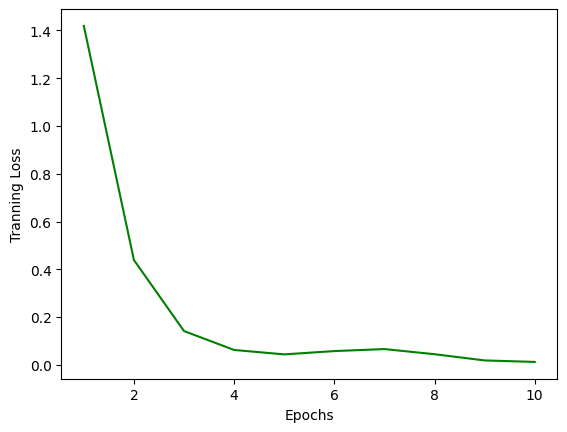

val_loss_history : [0.9157246567986228, 0.81667806614529, 0.9648954570293427, 0.9332846105098724, 1.0264740730776931, 1.2189217191753965, 1.1807875244906454, 1.0748724305268489, 1.0684576413848184, 1.1377571071639205]


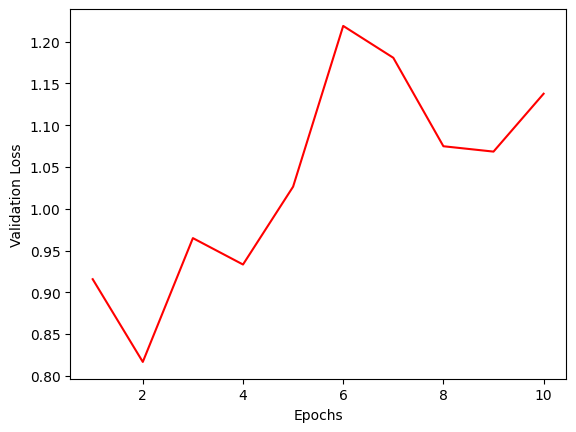

val_score_history : [0.676316187707583, 0.7351592774836778, 0.7264514508873243, 0.7589373631220424, 0.7490326309824735, 0.7351814306315139, 0.741861711180319, 0.763772232676376, 0.7713908945919916, 0.7661110533231733]


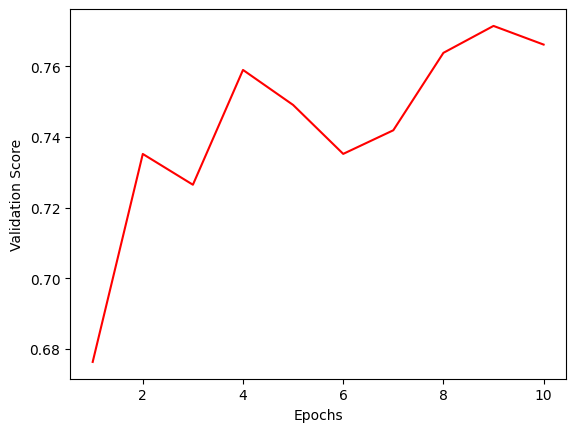

In [18]:
model = BaseModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

## Inference

In [19]:
# 테스트 csv 파일 경로 수정
# test = pd.read_csv('../../open/test.csv')
test = pd.read_csv('/content/test.csv')

In [20]:
# ======== 테스트 이미지 파일 경로 수정 ========

# test_img_paths = []

# for i in test['img_path'].values:

#     test_img_path = '../../open/' + i.replace('./', '')

#     test_img_paths.append(test_img_path)

# print('test_img_paths :', test_img_paths)

# test_dataset = CustomDataset(test_img_paths, None, test_transform)
test_dataset = CustomDataset(test['img_path'].values, None, test_transform)

# =============================================

test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [21]:
def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)
            
            pred = model(imgs)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
    
    preds = le.inverse_transform(preds)
    return preds

In [22]:
preds = inference(infer_model, test_loader, device)

  0%|          | 0/25 [00:00<?, ?it/s]

## Submission

In [23]:
# 제출용 추론 결과 csv 파일 경로 수정
# submit = pd.read_csv('../../open/sample_submission.csv')
submit = pd.read_csv('/content/sample_submission.csv')

In [24]:
submit['label'] = preds

In [25]:
submit.to_csv('./v2_baseline_submit.csv', index=False)

In [26]:
print('predicted_defect_types :')
print(submit['label'].value_counts())

predicted_defect_types :
훼손         352
오염         237
터짐          31
꼬임          29
오타공         23
면불량         19
걸레받이수정      19
석고수정        18
몰딩수정        18
곰팡이         16
피스           8
들뜸           8
이음부불량        5
창틀,문틀수정      5
가구수정         3
녹오염          1
Name: label, dtype: int64


In [1]:
# v2.1.1 csv 파일과 비교
predicted_defect_types = pd.read_csv('v2_1_1_baseline_submit.csv')
print('predicted_defect_types :')
print(predicted_defect_types['label'].value_counts())

predicted_defect_types :
label
훼손         330
오염         256
꼬임          45
터짐          38
오타공         20
걸레받이수정      16
곰팡이         16
면불량         12
몰딩수정        12
피스          11
들뜸           9
석고수정         8
가구수정         6
이음부불량        4
창틀,문틀수정      4
녹오염          4
울음           1
Name: count, dtype: int64
